# ::: Test fine-tuning Yolo-NAS 모델 :::

# 1. Import Packages and Modules

In [1]:
# from super_gradients.training import Trainer
from super_gradients import Trainer
from super_gradients.training import MultiGPUMode
from super_gradients.training import dataloaders
# # 학습과 검증 데이터 정의하기 위한 모듈
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
# # Yolo-NAS가 사용하는 loss : PPYoloELoss
from super_gradients.training.losses import PPYoloELoss
# # 50% IoU에 mAP를 모니터링하기 위한 모듈
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm
 
import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

/home/astroboi/anaconda3/envs/yolonas/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-01-15 14:33:13] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/astroboi/sg_logs/console.log


[2024-01-15 14:33:16] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-15 14:33:16] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-15 14:33:16] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-15 14:33:16] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

In [3]:
# from super_gradients.training.utils.distributed_training_utils import setup_device
# from super_gradients.common.data_types.enum import MultiGPUMode
# setup_device(multi_gpu=MultiGPUMode.DISTRIBUTED_DATA_PARALLEL, num_gpus=2)

# 2. Custom datase hierarchy

# 3. Set dataset parameters for training Yolo-NAS

In [4]:
ROOT_DIR = './app_data2'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Icon', 'Container', 'Text', 'Text_Field', 'Check_Box', 'Slide', 'Picture', 'Page_Control', 'AD', 'Segmentation_Control', 'Add', 'Radio_Button', 'Toggle', 'Play', 'Edit', 'Slider', 'Pause', 'Dialog', 'Keyboard', 'Create']
 
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}

In [5]:
# # check #classes
len(classes)

20

Device: cuda:1
Current cuda device: 0
Count of using GPUs: 2


# 4. Start Training

## 4-1. Set Global parameters

In [6]:
# Global parameters.
EPOCHS = 1000 # 500
BATCH_SIZE = 16 # // 2
WORKERS = 1

## 4-2. Define training/validation dataset for training Yolo-NAS

In [7]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
        # , 'input_dim': [480, 960]
    },
    # # data loading process 위해 batch 크기, worker 수 셋팅
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)
 
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
        # , 'input_dim': [480, 960]
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations: 100%|██████████| 89/89 [00:00<00:00, 3820.93it/s]


## 4-3. Check dataset 

### 4-3-1 Check train data set

In [8]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

### 4-3-2. Check one of train data set

In [9]:
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

### 4-3-3. Check train data set as images

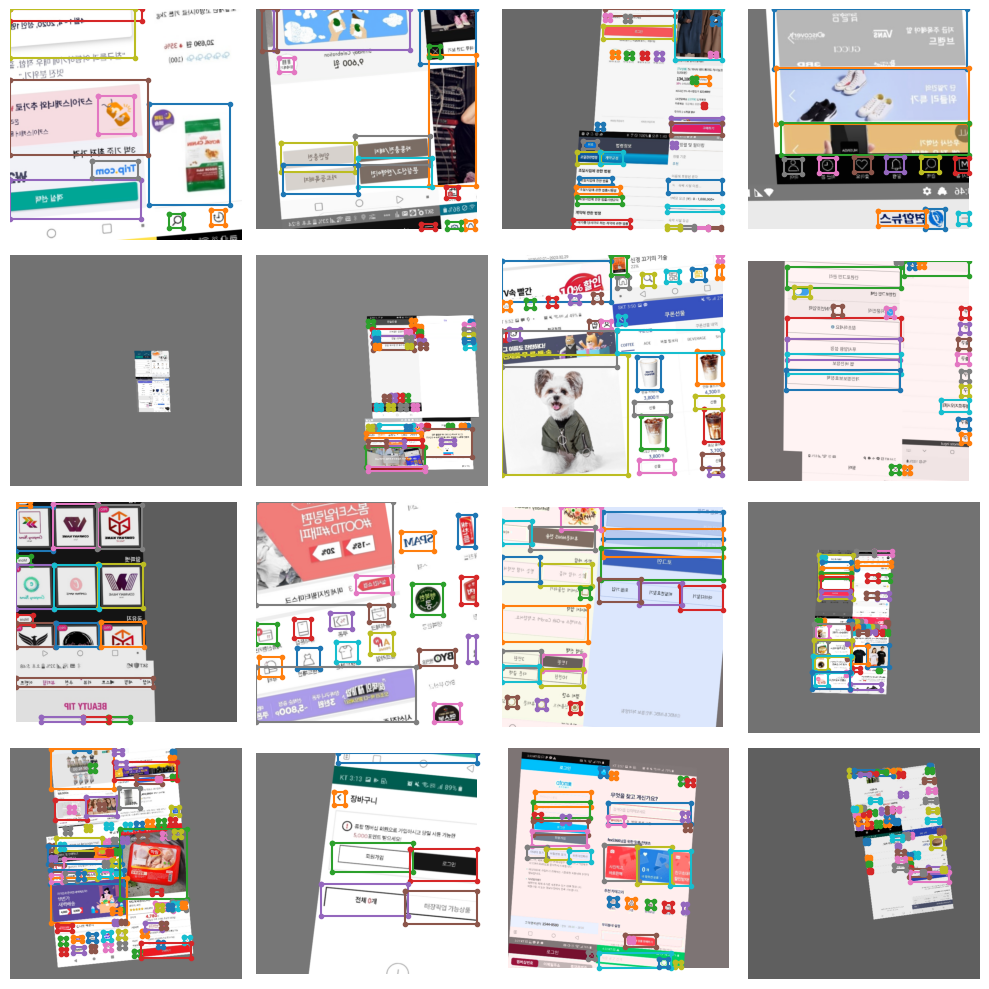

In [10]:
train_data.dataset.plot(plot_transformed_data=True)

## 4-4. Set train parameters

In [11]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

## 4-5. Check checkpoint dir 

In [12]:
# import torch.nn as nn
# # Set Multi-GPU
# from super_gradients.common.data_types.enum import MultiGPUMode
# import super_gradients
# from super_gradients.training import MultiGPUMode
# # from super_gradients.common import MultiGPUMode
# super_gradients.setup_device(device='cuda', multi_gpu=MultiGPUMode.DISTRIBUTED_DATA_PARALLEL, num_gpus=2)  #  multi_gpu=...,
# # DATA_PARALLEL, DISTRIBUTED_DATA_PARALLEL
# super_gradients.setup_device(multi_gpu=MultiGPUMode.DISTRIBUTED_DATA_PARALLEL, num_gpus=2, device='cuda')
# # from super_gradients.training.utils.distributed_training_utils import setup_device
# # setup_device(multi_gpu='DP', num_gpus=2)
# # setup_device(num_gpus=2)

# yolo_nas_m 이상은 Out of Memory 나고 있음. TODO: multi-GPU 연구해야 함
models_to_train = ['yolo_nas_s']
# models_to_train = ['yolo_nas_m']
# models_to_train = ['yolo_nas_l']

# models_to_train = [
#     'yolo_nas_m',
#     'yolo_nas_l'
# ]
 
from datetime import datetime
CHECKPOINT_DIR = f'checkpoints/{datetime.now().strftime("%Y%m%d_%H:%M:%S")}'
print(f"CHECKPOINT_DIR :::::::::::::::::::\n{CHECKPOINT_DIR}")

CHECKPOINT_DIR :::::::::::::::::::
checkpoints/20240115_14:33:26


## 4-6. Train!!!

In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
        # , multi_gpu=MultiGPUMode.DATA_PARALLEL
    )
 
    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )
    
    # if torch.cuda.device_count() > 1:
    #     print("Let's use", torch.cuda.device_count(), "GPUs!")
    #     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #     model = nn.DataParallel(model)
    # model.to([0, 1])
    # train_data = train_data.to(device)
 
    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2024-01-15 14:33:33] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-01-15 14:33:35] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/20240115_14:33:26/yolo_nas_s/console_ 1월15_14_33_35.txt


[2024-01-15 14:33:37] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Dataset size:                 934        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         58         (len(train_loader))
    - Gradient updates per epoch:   58         (len(train_loader) / batch_accumulate)

[2024-01-15 14:33:37] INFO - sg_trainer.py - Started training for 1000 epochs (0/999)

Validation epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.7344
│   ├── Ppyoloeloss/loss_cls = 2.3041
│   ├── Ppyoloeloss/loss_dfl = 1.2854
│   └── Ppyoloeloss/loss_iou = 0.315
└── Validation
    ├── F1@0.50 = 0.0002
    ├── F1@0.50:0.95 = 0.0001
    ├── Map@0.50 = 0.0006
    ├── Map@0.50:0.95 = 0.0004
    ├── Ppyoloeloss/loss = 3.5049
    ├── Ppyoloeloss/loss_cls = 2.348
    ├── Ppyoloeloss/loss_dfl = 0.9728
    ├── Ppyoloeloss/loss_iou = 0.2682
    ├── Precision@0.50 = 0.0196
    ├── Precision@0.50:0.95 = 0.0127
    ├── Recall@0.50 = 0.0001
    └── Recall@0.50:0.95 = 0.0001



[2024-01-15 14:34:53] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 14:34:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.00035917566856369376
Validation epoch 1: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.3303
│   │   ├── Best until now = 3.7344 (↘ -1.4041)
│   │   └── Epoch N-1      = 3.7344 (↘ -1.4041)
│   ├── Ppyoloeloss/loss_cls = 1.3375
│   │   ├── Best until now = 2.3041 (↘ -0.9666)
│   │   └── Epoch N-1      = 2.3041 (↘ -0.9666)
│   ├── Ppyoloeloss/loss_dfl = 0.8933
│   │   ├── Best until now = 1.2854 (↘ -0.3921)
│   │   └── Epoch N-1      = 1.2854 (↘ -0.3921)
│   └── Ppyoloeloss/loss_iou = 0.2185
│       ├── Best until now = 0.315  (↘ -0.0966)
│       └── Epoch N-1      = 0.315  (↘ -0.0966)
└── Validation
    ├── F1@0.50 = 0.0305
    │   ├── Best until now = 0.0002 (↗ 0.0303)
    │   └── Epoch N-1      = 0.0002 (↗ 0.0303)
    ├── F1@0.50:0.95 = 0.018
    │   ├── Best until now = 0.0001 (↗ 0.0179)
    │   └── Epoch N-1      = 0.0001 (↗ 0.0179)
    ├── Map@0.50 = 0.1216
    │   ├── Best until now = 0.0006 (↗ 0.121)
    │   └── Epoch N-1      = 0.0006 (↗ 0.121)
    ├── Map@0.50:0.95 = 0.0747
    │   ├── Best until now = 0

[2024-01-15 14:36:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 14:36:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.07469885796308517
Validation epoch 2: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.9626
│   │   ├── Best until now = 2.3303 (↘ -0.3677)
│   │   └── Epoch N-1      = 2.3303 (↘ -0.3677)
│   ├── Ppyoloeloss/loss_cls = 1.0821
│   │   ├── Best until now = 1.3375 (↘ -0.2554)
│   │   └── Epoch N-1      = 1.3375 (↘ -0.2554)
│   ├── Ppyoloeloss/loss_dfl = 0.812
│   │   ├── Best until now = 0.8933 (↘ -0.0812)
│   │   └── Epoch N-1      = 0.8933 (↘ -0.0812)
│   └── Ppyoloeloss/loss_iou = 0.1898
│       ├── Best until now = 0.2185 (↘ -0.0287)
│       └── Epoch N-1      = 0.2185 (↘ -0.0287)
└── Validation
    ├── F1@0.50 = 0.0683
    │   ├── Best until now = 0.0305 (↗ 0.0379)
    │   └── Epoch N-1      = 0.0305 (↗ 0.0379)
    ├── F1@0.50:0.95 = 0.0416
    │   ├── Best until now = 0.018  (↗ 0.0236)
    │   └── Epoch N-1      = 0.018  (↗ 0.0236)
    ├── Map@0.50 = 0.0934
    │   ├── Best until now = 0.1216 (↘ -0.0282)
    │   └── Epoch N-1      = 0.1216 (↘ -0.0282)
    ├── Map@0.50:0.95 = 0.0516
    │   ├── Best until now

Validation epoch 3: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.8834
│   │   ├── Best until now = 1.9626 (↘ -0.0792)
│   │   └── Epoch N-1      = 1.9626 (↘ -0.0792)
│   ├── Ppyoloeloss/loss_cls = 1.0276
│   │   ├── Best until now = 1.0821 (↘ -0.0545)
│   │   └── Epoch N-1      = 1.0821 (↘ -0.0545)
│   ├── Ppyoloeloss/loss_dfl = 0.8008
│   │   ├── Best until now = 0.812  (↘ -0.0112)
│   │   └── Epoch N-1      = 0.812  (↘ -0.0112)
│   └── Ppyoloeloss/loss_iou = 0.1822
│       ├── Best until now = 0.1898 (↘ -0.0076)
│       └── Epoch N-1      = 0.1898 (↘ -0.0076)
└── Validation
    ├── F1@0.50 = 0.0506
    │   ├── Best until now = 0.0683 (↘ -0.0177)
    │   └── Epoch N-1      = 0.0683 (↘ -0.0177)
    ├── F1@0.50:0.95 = 0.0307
    │   ├── Best until now = 0.0416 (↘ -0.0109)
    │   └── Epoch N-1      = 0.0416 (↘ -0.0109)
    ├── Map@0.50 = 0.2035
    │   ├── Best until now = 0.1216 (↗ 0.0818)
    │   └── Epoch N-1      = 0.0934 (↗ 0.11)
    ├── Map@0.50:0.95 = 0.1081
    │   ├── Best until no

[2024-01-15 14:38:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 14:38:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.10807560384273529
Validation epoch 4: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 1.8074
│   │   ├── Best until now = 1.8834 (↘ -0.076)
│   │   └── Epoch N-1      = 1.8834 (↘ -0.076)
│   ├── Ppyoloeloss/loss_cls = 0.9777
│   │   ├── Best until now = 1.0276 (↘ -0.0498)
│   │   └── Epoch N-1      = 1.0276 (↘ -0.0498)
│   ├── Ppyoloeloss/loss_dfl = 0.7822
│   │   ├── Best until now = 0.8008 (↘ -0.0187)
│   │   └── Epoch N-1      = 0.8008 (↘ -0.0187)
│   └── Ppyoloeloss/loss_iou = 0.1754
│       ├── Best until now = 0.1822 (↘ -0.0067)
│       └── Epoch N-1      = 0.1822 (↘ -0.0067)
└── Validation
    ├── F1@0.50 = 0.0502
    │   ├── Best until now = 0.0683 (↘ -0.0181)
    │   └── Epoch N-1      = 0.0506 (↘ -0.0004)
    ├── F1@0.50:0.95 = 0.0329
    │   ├── Best until now = 0.0416 (↘ -0.0087)
    │   └── Epoch N-1      = 0.0307 (↗ 0.0022)
    ├── Map@0.50 = 0.1621
    │   ├── Best until now = 0.2035 (↘ -0.0414)
    │   └── Epoch N-1      = 0.2035 (↘ -0.0414)
    ├── Map@0.50:0.95 = 0.0911
    │   ├── Best until n

Validation epoch 5: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.7662
│   │   ├── Best until now = 1.8074 (↘ -0.0412)
│   │   └── Epoch N-1      = 1.8074 (↘ -0.0412)
│   ├── Ppyoloeloss/loss_cls = 0.9583
│   │   ├── Best until now = 0.9777 (↘ -0.0194)
│   │   └── Epoch N-1      = 0.9777 (↘ -0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.7646
│   │   ├── Best until now = 0.7822 (↘ -0.0176)
│   │   └── Epoch N-1      = 0.7822 (↘ -0.0176)
│   └── Ppyoloeloss/loss_iou = 0.1702
│       ├── Best until now = 0.1754 (↘ -0.0052)
│       └── Epoch N-1      = 0.1754 (↘ -0.0052)
└── Validation
    ├── F1@0.50 = 0.0788
    │   ├── Best until now = 0.0683 (↗ 0.0104)
    │   └── Epoch N-1      = 0.0502 (↗ 0.0286)
    ├── F1@0.50:0.95 = 0.0483
    │   ├── Best until now = 0.0416 (↗ 0.0066)
    │   └── Epoch N-1      = 0.0329 (↗ 0.0154)
    ├── Map@0.50 = 0.1996
    │   ├── Best until now = 0.2035 (↘ -0.0038)
    │   └── Epoch N-1      = 0.1621 (↗ 0.0376)
    ├── Map@0.50:0.95 = 0.1158
    │   ├── Best until now

[2024-01-15 14:41:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 14:41:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1157635822892189
Validation epoch 6: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.7425
│   │   ├── Best until now = 1.7662 (↘ -0.0237)
│   │   └── Epoch N-1      = 1.7662 (↘ -0.0237)
│   ├── Ppyoloeloss/loss_cls = 0.9356
│   │   ├── Best until now = 0.9583 (↘ -0.0227)
│   │   └── Epoch N-1      = 0.9583 (↘ -0.0227)
│   ├── Ppyoloeloss/loss_dfl = 0.7621
│   │   ├── Best until now = 0.7646 (↘ -0.0025)
│   │   └── Epoch N-1      = 0.7646 (↘ -0.0025)
│   └── Ppyoloeloss/loss_iou = 0.1704
│       ├── Best until now = 0.1702 (↗ 1e-04)
│       └── Epoch N-1      = 0.1702 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.0741
    │   ├── Best until now = 0.0788 (↘ -0.0047)
    │   └── Epoch N-1      = 0.0788 (↘ -0.0047)
    ├── F1@0.50:0.95 = 0.0483
    │   ├── Best until now = 0.0483 (↗ 0.0)
    │   └── Epoch N-1      = 0.0483 (↗ 0.0)
    ├── Map@0.50 = 0.3259
    │   ├── Best until now = 0.2035 (↗ 0.1225)
    │   └── Epoch N-1      = 0.1996 (↗ 0.1263)
    ├── Map@0.50:0.95 = 0.1972
    │   ├── Best until now = 0.1158

[2024-01-15 14:42:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 14:42:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19715707004070282
Validation epoch 7: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.7099
│   │   ├── Best until now = 1.7425 (↘ -0.0327)
│   │   └── Epoch N-1      = 1.7425 (↘ -0.0327)
│   ├── Ppyoloeloss/loss_cls = 0.9185
│   │   ├── Best until now = 0.9356 (↘ -0.0172)
│   │   └── Epoch N-1      = 0.9356 (↘ -0.0172)
│   ├── Ppyoloeloss/loss_dfl = 0.7526
│   │   ├── Best until now = 0.7621 (↘ -0.0095)
│   │   └── Epoch N-1      = 0.7621 (↘ -0.0095)
│   └── Ppyoloeloss/loss_iou = 0.1661
│       ├── Best until now = 0.1702 (↘ -0.0042)
│       └── Epoch N-1      = 0.1704 (↘ -0.0043)
└── Validation
    ├── F1@0.50 = 0.0747
    │   ├── Best until now = 0.0788 (↘ -0.0041)
    │   └── Epoch N-1      = 0.0741 (↗ 0.0006)
    ├── F1@0.50:0.95 = 0.0484
    │   ├── Best until now = 0.0483 (↗ 0.0001)
    │   └── Epoch N-1      = 0.0483 (↗ 0.0001)
    ├── Map@0.50 = 0.2616
    │   ├── Best until now = 0.3259 (↘ -0.0643)
    │   └── Epoch N-1      = 0.3259 (↘ -0.0643)
    ├── Map@0.50:0.95 = 0.1541
    │   ├── Best until n

Validation epoch 8: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.7188
│   │   ├── Best until now = 1.7099 (↗ 0.009)
│   │   └── Epoch N-1      = 1.7099 (↗ 0.009)
│   ├── Ppyoloeloss/loss_cls = 0.9222
│   │   ├── Best until now = 0.9185 (↗ 0.0038)
│   │   └── Epoch N-1      = 0.9185 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.7551
│   │   ├── Best until now = 0.7526 (↗ 0.0026)
│   │   └── Epoch N-1      = 0.7526 (↗ 0.0026)
│   └── Ppyoloeloss/loss_iou = 0.1676
│       ├── Best until now = 0.1661 (↗ 0.0016)
│       └── Epoch N-1      = 0.1661 (↗ 0.0016)
└── Validation
    ├── F1@0.50 = 0.0818
    │   ├── Best until now = 0.0788 (↗ 0.003)
    │   └── Epoch N-1      = 0.0747 (↗ 0.0072)
    ├── F1@0.50:0.95 = 0.0556
    │   ├── Best until now = 0.0484 (↗ 0.0072)
    │   └── Epoch N-1      = 0.0484 (↗ 0.0072)
    ├── Map@0.50 = 0.2878
    │   ├── Best until now = 0.3259 (↘ -0.0382)
    │   └── Epoch N-1      = 0.2616 (↗ 0.0261)
    ├── Map@0.50:0.95 = 0.1813
    │   ├── Best until now = 0.1972 (

Validation epoch 9: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.6961
│   │   ├── Best until now = 1.7099 (↘ -0.0138)
│   │   └── Epoch N-1      = 1.7188 (↘ -0.0227)
│   ├── Ppyoloeloss/loss_cls = 0.9037
│   │   ├── Best until now = 0.9185 (↘ -0.0148)
│   │   └── Epoch N-1      = 0.9222 (↘ -0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.7514
│   │   ├── Best until now = 0.7526 (↘ -0.0012)
│   │   └── Epoch N-1      = 0.7551 (↘ -0.0037)
│   └── Ppyoloeloss/loss_iou = 0.1667
│       ├── Best until now = 0.1661 (↗ 0.0006)
│       └── Epoch N-1      = 0.1676 (↘ -0.0009)
└── Validation
    ├── F1@0.50 = 0.0835
    │   ├── Best until now = 0.0818 (↗ 0.0017)
    │   └── Epoch N-1      = 0.0818 (↗ 0.0017)
    ├── F1@0.50:0.95 = 0.0571
    │   ├── Best until now = 0.0556 (↗ 0.0015)
    │   └── Epoch N-1      = 0.0556 (↗ 0.0015)
    ├── Map@0.50 = 0.4103
    │   ├── Best until now = 0.3259 (↗ 0.0844)
    │   └── Epoch N-1      = 0.2878 (↗ 0.1225)
    ├── Map@0.50:0.95 = 0.2856
    │   ├── Best until now =

[2024-01-15 14:46:34] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 14:46:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2855675220489502
Validation epoch 10: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.6542
│   │   ├── Best until now = 1.6961 (↘ -0.0419)
│   │   └── Epoch N-1      = 1.6961 (↘ -0.0419)
│   ├── Ppyoloeloss/loss_cls = 0.8867
│   │   ├── Best until now = 0.9037 (↘ -0.0169)
│   │   └── Epoch N-1      = 0.9037 (↘ -0.0169)
│   ├── Ppyoloeloss/loss_dfl = 0.7366
│   │   ├── Best until now = 0.7514 (↘ -0.0148)
│   │   └── Epoch N-1      = 0.7514 (↘ -0.0148)
│   └── Ppyoloeloss/loss_iou = 0.1597
│       ├── Best until now = 0.1661 (↘ -0.0064)
│       └── Epoch N-1      = 0.1667 (↘ -0.007)
└── Validation
    ├── F1@0.50 = 0.128
    │   ├── Best until now = 0.0835 (↗ 0.0445)
    │   └── Epoch N-1      = 0.0835 (↗ 0.0445)
    ├── F1@0.50:0.95 = 0.0893
    │   ├── Best until now = 0.0571 (↗ 0.0322)
    │   └── Epoch N-1      = 0.0571 (↗ 0.0322)
    ├── Map@0.50 = 0.3478
    │   ├── Best until now = 0.4103 (↘ -0.0625)
    │   └── Epoch N-1      = 0.4103 (↘ -0.0625)
    ├── Map@0.50:0.95 = 0.2241
    │   ├── Best until now

Validation epoch 11: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 1.6825
│   │   ├── Best until now = 1.6542 (↗ 0.0283)
│   │   └── Epoch N-1      = 1.6542 (↗ 0.0283)
│   ├── Ppyoloeloss/loss_cls = 0.8963
│   │   ├── Best until now = 0.8867 (↗ 0.0096)
│   │   └── Epoch N-1      = 0.8867 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.7485
│   │   ├── Best until now = 0.7366 (↗ 0.0119)
│   │   └── Epoch N-1      = 0.7366 (↗ 0.0119)
│   └── Ppyoloeloss/loss_iou = 0.1648
│       ├── Best until now = 0.1597 (↗ 0.0051)
│       └── Epoch N-1      = 0.1597 (↗ 0.0051)
└── Validation
    ├── F1@0.50 = 0.0803
    │   ├── Best until now = 0.128  (↘ -0.0477)
    │   └── Epoch N-1      = 0.128  (↘ -0.0477)
    ├── F1@0.50:0.95 = 0.0531
    │   ├── Best until now = 0.0893 (↘ -0.0362)
    │   └── Epoch N-1      = 0.0893 (↘ -0.0362)
    ├── Map@0.50 = 0.4455
    │   ├── Best until now = 0.4103 (↗ 0.0352)
    │   └── Epoch N-1      = 0.3478 (↗ 0.0977)
    ├── Map@0.50:0.95 = 0.2797
    │   ├── Best until now = 0

Validation epoch 12: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 1.6642
│   │   ├── Best until now = 1.6542 (↗ 0.01)
│   │   └── Epoch N-1      = 1.6825 (↘ -0.0183)
│   ├── Ppyoloeloss/loss_cls = 0.8907
│   │   ├── Best until now = 0.8867 (↗ 0.004)
│   │   └── Epoch N-1      = 0.8963 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.7412
│   │   ├── Best until now = 0.7366 (↗ 0.0046)
│   │   └── Epoch N-1      = 0.7485 (↘ -0.0074)
│   └── Ppyoloeloss/loss_iou = 0.1612
│       ├── Best until now = 0.1597 (↗ 0.0015)
│       └── Epoch N-1      = 0.1648 (↘ -0.0036)
└── Validation
    ├── F1@0.50 = 0.0933
    │   ├── Best until now = 0.128  (↘ -0.0347)
    │   └── Epoch N-1      = 0.0803 (↗ 0.013)
    ├── F1@0.50:0.95 = 0.0652
    │   ├── Best until now = 0.0893 (↘ -0.0241)
    │   └── Epoch N-1      = 0.0531 (↗ 0.0121)
    ├── Map@0.50 = 0.4373
    │   ├── Best until now = 0.4455 (↘ -0.0081)
    │   └── Epoch N-1      = 0.4455 (↘ -0.0081)
    ├── Map@0.50:0.95 = 0.2929
    │   ├── Best until now = 0

[2024-01-15 14:50:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 14:50:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2929340898990631
Validation epoch 13: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 1.632
│   │   ├── Best until now = 1.6542 (↘ -0.0221)
│   │   └── Epoch N-1      = 1.6642 (↘ -0.0322)
│   ├── Ppyoloeloss/loss_cls = 0.8639
│   │   ├── Best until now = 0.8867 (↘ -0.0229)
│   │   └── Epoch N-1      = 0.8907 (↘ -0.0269)
│   ├── Ppyoloeloss/loss_dfl = 0.7373
│   │   ├── Best until now = 0.7366 (↗ 0.0007)
│   │   └── Epoch N-1      = 0.7412 (↘ -0.0039)
│   └── Ppyoloeloss/loss_iou = 0.1598
│       ├── Best until now = 0.1597 (↗ 0.0002)
│       └── Epoch N-1      = 0.1612 (↘ -0.0013)
└── Validation
    ├── F1@0.50 = 0.0935
    │   ├── Best until now = 0.128  (↘ -0.0345)
    │   └── Epoch N-1      = 0.0933 (↗ 0.0002)
    ├── F1@0.50:0.95 = 0.0686
    │   ├── Best until now = 0.0893 (↘ -0.0207)
    │   └── Epoch N-1      = 0.0652 (↗ 0.0034)
    ├── Map@0.50 = 0.4907
    │   ├── Best until now = 0.4455 (↗ 0.0452)
    │   └── Epoch N-1      = 0.4373 (↗ 0.0534)
    ├── Map@0.50:0.95 = 0.3406
    │   ├── Best until now 

[2024-01-15 14:51:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 14:51:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.34062397480010986
Validation epoch 14: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 1.6254
│   │   ├── Best until now = 1.632  (↘ -0.0066)
│   │   └── Epoch N-1      = 1.632  (↘ -0.0066)
│   ├── Ppyoloeloss/loss_cls = 0.863
│   │   ├── Best until now = 0.8639 (↘ -0.0009)
│   │   └── Epoch N-1      = 0.8639 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.7315
│   │   ├── Best until now = 0.7366 (↘ -0.0051)
│   │   └── Epoch N-1      = 0.7373 (↘ -0.0058)
│   └── Ppyoloeloss/loss_iou = 0.1587
│       ├── Best until now = 0.1597 (↘ -0.001)
│       └── Epoch N-1      = 0.1598 (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.0859
    │   ├── Best until now = 0.128  (↘ -0.0421)
    │   └── Epoch N-1      = 0.0935 (↘ -0.0076)
    ├── F1@0.50:0.95 = 0.0609
    │   ├── Best until now = 0.0893 (↘ -0.0284)
    │   └── Epoch N-1      = 0.0686 (↘ -0.0077)
    ├── Map@0.50 = 0.4599
    │   ├── Best until now = 0.4907 (↘ -0.0308)
    │   └── Epoch N-1      = 0.4907 (↘ -0.0308)
    ├── Map@0.50:0.95 = 0.2898
    │   ├── Best until

Validation epoch 15: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.6286
│   │   ├── Best until now = 1.6254 (↗ 0.0031)
│   │   └── Epoch N-1      = 1.6254 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_cls = 0.8616
│   │   ├── Best until now = 0.863  (↘ -0.0014)
│   │   └── Epoch N-1      = 0.863  (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.7356
│   │   ├── Best until now = 0.7315 (↗ 0.0041)
│   │   └── Epoch N-1      = 0.7315 (↗ 0.0041)
│   └── Ppyoloeloss/loss_iou = 0.1597
│       ├── Best until now = 0.1587 (↗ 0.001)
│       └── Epoch N-1      = 0.1587 (↗ 0.001)
└── Validation
    ├── F1@0.50 = 0.1084
    │   ├── Best until now = 0.128  (↘ -0.0196)
    │   └── Epoch N-1      = 0.0859 (↗ 0.0225)
    ├── F1@0.50:0.95 = 0.0794
    │   ├── Best until now = 0.0893 (↘ -0.0099)
    │   └── Epoch N-1      = 0.0609 (↗ 0.0184)
    ├── Map@0.50 = 0.4687
    │   ├── Best until now = 0.4907 (↘ -0.022)
    │   └── Epoch N-1      = 0.4599 (↗ 0.0088)
    ├── Map@0.50:0.95 = 0.3294
    │   ├── Best until now = 0.3

Validation epoch 16: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


SUMMARY OF EPOCH 16
├── Training
│   ├── Ppyoloeloss/loss = 1.651
│   │   ├── Best until now = 1.6254 (↗ 0.0256)
│   │   └── Epoch N-1      = 1.6286 (↗ 0.0224)
│   ├── Ppyoloeloss/loss_cls = 0.8798
│   │   ├── Best until now = 0.8616 (↗ 0.0182)
│   │   └── Epoch N-1      = 0.8616 (↗ 0.0182)
│   ├── Ppyoloeloss/loss_dfl = 0.7383
│   │   ├── Best until now = 0.7315 (↗ 0.0069)
│   │   └── Epoch N-1      = 0.7356 (↗ 0.0028)
│   └── Ppyoloeloss/loss_iou = 0.1608
│       ├── Best until now = 0.1587 (↗ 0.0021)
│       └── Epoch N-1      = 0.1597 (↗ 0.0011)
└── Validation
    ├── F1@0.50 = 0.1051
    │   ├── Best until now = 0.128  (↘ -0.0229)
    │   └── Epoch N-1      = 0.1084 (↘ -0.0033)
    ├── F1@0.50:0.95 = 0.072
    │   ├── Best until now = 0.0893 (↘ -0.0173)
    │   └── Epoch N-1      = 0.0794 (↘ -0.0074)
    ├── Map@0.50 = 0.39
    │   ├── Best until now = 0.4907 (↘ -0.1008)
    │   └── Epoch N-1      = 0.4687 (↘ -0.0788)
    ├── Map@0.50:0.95 = 0.2496
    │   ├── Best until now = 0.3

Validation epoch 17: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


SUMMARY OF EPOCH 17
├── Training
│   ├── Ppyoloeloss/loss = 1.6038
│   │   ├── Best until now = 1.6254 (↘ -0.0216)
│   │   └── Epoch N-1      = 1.651  (↘ -0.0472)
│   ├── Ppyoloeloss/loss_cls = 0.8492
│   │   ├── Best until now = 0.8616 (↘ -0.0124)
│   │   └── Epoch N-1      = 0.8798 (↘ -0.0307)
│   ├── Ppyoloeloss/loss_dfl = 0.7317
│   │   ├── Best until now = 0.7315 (↗ 0.0002)
│   │   └── Epoch N-1      = 0.7383 (↘ -0.0067)
│   └── Ppyoloeloss/loss_iou = 0.1555
│       ├── Best until now = 0.1587 (↘ -0.0032)
│       └── Epoch N-1      = 0.1608 (↘ -0.0053)
└── Validation
    ├── F1@0.50 = 0.0949
    │   ├── Best until now = 0.128  (↘ -0.0332)
    │   └── Epoch N-1      = 0.1051 (↘ -0.0103)
    ├── F1@0.50:0.95 = 0.063
    │   ├── Best until now = 0.0893 (↘ -0.0263)
    │   └── Epoch N-1      = 0.072  (↘ -0.009)
    ├── Map@0.50 = 0.478
    │   ├── Best until now = 0.4907 (↘ -0.0127)
    │   └── Epoch N-1      = 0.39   (↗ 0.088)
    ├── Map@0.50:0.95 = 0.2656
    │   ├── Best until now

Validation epoch 18: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


SUMMARY OF EPOCH 18
├── Training
│   ├── Ppyoloeloss/loss = 1.5668
│   │   ├── Best until now = 1.6038 (↘ -0.037)
│   │   └── Epoch N-1      = 1.6038 (↘ -0.037)
│   ├── Ppyoloeloss/loss_cls = 0.8253
│   │   ├── Best until now = 0.8492 (↘ -0.0238)
│   │   └── Epoch N-1      = 0.8492 (↘ -0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.7212
│   │   ├── Best until now = 0.7315 (↘ -0.0103)
│   │   └── Epoch N-1      = 0.7317 (↘ -0.0105)
│   └── Ppyoloeloss/loss_iou = 0.1523
│       ├── Best until now = 0.1555 (↘ -0.0032)
│       └── Epoch N-1      = 0.1555 (↘ -0.0032)
└── Validation
    ├── F1@0.50 = 0.0998
    │   ├── Best until now = 0.128  (↘ -0.0283)
    │   └── Epoch N-1      = 0.0949 (↗ 0.0049)
    ├── F1@0.50:0.95 = 0.0681
    │   ├── Best until now = 0.0893 (↘ -0.0212)
    │   └── Epoch N-1      = 0.063  (↗ 0.0051)
    ├── Map@0.50 = 0.4356
    │   ├── Best until now = 0.4907 (↘ -0.0551)
    │   └── Epoch N-1      = 0.478  (↘ -0.0424)
    ├── Map@0.50:0.95 = 0.2854
    │   ├── Best until n

Validation epoch 19: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


SUMMARY OF EPOCH 19
├── Training
│   ├── Ppyoloeloss/loss = 1.6018
│   │   ├── Best until now = 1.5668 (↗ 0.035)
│   │   └── Epoch N-1      = 1.5668 (↗ 0.035)
│   ├── Ppyoloeloss/loss_cls = 0.8497
│   │   ├── Best until now = 0.8253 (↗ 0.0243)
│   │   └── Epoch N-1      = 0.8253 (↗ 0.0243)
│   ├── Ppyoloeloss/loss_dfl = 0.7239
│   │   ├── Best until now = 0.7212 (↗ 0.0027)
│   │   └── Epoch N-1      = 0.7212 (↗ 0.0027)
│   └── Ppyoloeloss/loss_iou = 0.1561
│       ├── Best until now = 0.1523 (↗ 0.0037)
│       └── Epoch N-1      = 0.1523 (↗ 0.0037)
└── Validation
    ├── F1@0.50 = 0.1025
    │   ├── Best until now = 0.128  (↘ -0.0256)
    │   └── Epoch N-1      = 0.0998 (↗ 0.0027)
    ├── F1@0.50:0.95 = 0.0692
    │   ├── Best until now = 0.0893 (↘ -0.0201)
    │   └── Epoch N-1      = 0.0681 (↗ 0.0011)
    ├── Map@0.50 = 0.4022
    │   ├── Best until now = 0.4907 (↘ -0.0885)
    │   └── Epoch N-1      = 0.4356 (↘ -0.0334)
    ├── Map@0.50:0.95 = 0.2576
    │   ├── Best until now = 0.3

Validation epoch 20: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 1.5903
│   │   ├── Best until now = 1.5668 (↗ 0.0235)
│   │   └── Epoch N-1      = 1.6018 (↘ -0.0115)
│   ├── Ppyoloeloss/loss_cls = 0.838
│   │   ├── Best until now = 0.8253 (↗ 0.0126)
│   │   └── Epoch N-1      = 0.8497 (↘ -0.0117)
│   ├── Ppyoloeloss/loss_dfl = 0.7239
│   │   ├── Best until now = 0.7212 (↗ 0.0027)
│   │   └── Epoch N-1      = 0.7239 (↘ -0.0)
│   └── Ppyoloeloss/loss_iou = 0.1562
│       ├── Best until now = 0.1523 (↗ 0.0038)
│       └── Epoch N-1      = 0.1561 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.1499
    │   ├── Best until now = 0.128  (↗ 0.0219)
    │   └── Epoch N-1      = 0.1025 (↗ 0.0475)
    ├── F1@0.50:0.95 = 0.0967
    │   ├── Best until now = 0.0893 (↗ 0.0074)
    │   └── Epoch N-1      = 0.0692 (↗ 0.0275)
    ├── Map@0.50 = 0.3807
    │   ├── Best until now = 0.4907 (↘ -0.11)
    │   └── Epoch N-1      = 0.4022 (↘ -0.0214)
    ├── Map@0.50:0.95 = 0.2437
    │   ├── Best until now = 0.3406 

Validation epoch 21: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


SUMMARY OF EPOCH 21
├── Training
│   ├── Ppyoloeloss/loss = 1.5855
│   │   ├── Best until now = 1.5668 (↗ 0.0187)
│   │   └── Epoch N-1      = 1.5903 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_cls = 0.8372
│   │   ├── Best until now = 0.8253 (↗ 0.0119)
│   │   └── Epoch N-1      = 0.838  (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.7256
│   │   ├── Best until now = 0.7212 (↗ 0.0044)
│   │   └── Epoch N-1      = 0.7239 (↗ 0.0018)
│   └── Ppyoloeloss/loss_iou = 0.1542
│       ├── Best until now = 0.1523 (↗ 0.0018)
│       └── Epoch N-1      = 0.1562 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.114
    │   ├── Best until now = 0.1499 (↘ -0.0359)
    │   └── Epoch N-1      = 0.1499 (↘ -0.0359)
    ├── F1@0.50:0.95 = 0.0831
    │   ├── Best until now = 0.0967 (↘ -0.0137)
    │   └── Epoch N-1      = 0.0967 (↘ -0.0137)
    ├── Map@0.50 = 0.5346
    │   ├── Best until now = 0.4907 (↗ 0.0439)
    │   └── Epoch N-1      = 0.3807 (↗ 0.1538)
    ├── Map@0.50:0.95 = 0.3749
    │   ├── Best until now = 

[2024-01-15 15:02:30] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/20240115_14:33:26/yolo_nas_s/ckpt_best.pth
[2024-01-15 15:02:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3748979866504669
Train epoch 22:  93%|█████████▎| 54/58 [01:06<00:05,  1.27s/it, PPYoloELoss/loss=1.6, PPYoloELoss/loss_cls=0.844, PPYoloELoss/loss_dfl=0.729, PPYoloELoss/loss_iou=0.157, gpu_mem=10]  

# 5. Check Tensorboard dashboard

In [1]:
# Launch after you have started training
import os
os.environ['TENSORBOARD_BINARY'] = '/home/astroboi/anaconda3/envs/yolonas/bin/tensorboard'
%load_ext tensorboard

In [4]:
# tensorboard logs save in the folder "runs"
%tensorboard --logdir checkpoints/20231129_09:30:18 --host 192.168.3.138
# %tensorboard --logdir checkpoints/20231129_09:30:18 --host 127.0.0.1

Reusing TensorBoard on port 6006 (pid 30812), started 0:07:22 ago. (Use '!kill 30812' to kill it.)

In [19]:
!kill 30793